Implementing Random Forest Regression model on the input data

Estimate and plot the Root Mean Square Error of 8 different test sets.

The idea is to do a train-test-split based on the typhoon's time. 
Therefore, typhoons are ordered with respect to their time of occurrence and then the 8 recent typhoons are selected as the test set (8 as a test over 39 typhoons in total means 20% as a test while 80% as a train). Then 8 different RMSEs are estimated while for each calculation one of the less recent typhoons was dropped from the test set and added to the train set. The idea is to determine how well the model performs in learning from older typhoons' characteristics to make predictions on the target value of the most recent ones.  


In [1]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
from sklearn.preprocessing import RobustScaler
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import geopandas as gpd
import importlib
from sklearn import preprocessing
import statistics
from sklearn.ensemble import RandomForestRegressor

wor_dir="/home/mforooshani/Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/"
os.chdir(wor_dir)
cdir = os.getcwd()

combined_input_data=pd.read_csv("Training-data-new/data/model_input/combined_input_data.csv")
#display(combined_input_data)

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]


def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    #elif ((v_max < x_max)  and  (rainfall_max_6h < y_max) ):
    #elif (v_max < x_max ):
    #value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")


np.mean(combined_input_data["DAM_perc_dmg"])
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])
np.unique(combined_input_data.typhoon)

def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 


combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])


features_name = combined_input_data.columns
#display(features_name)

features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary']


df=combined_input_data.dropna()
display(df)



,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568
2,durian2006,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.00,...,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000
4,durian2006,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,1.28,...,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000
6,durian2006,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,...,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000
7,durian2006,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.36,...,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,noul2015,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,6.25,...,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000
25837,noul2015,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,...,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000
25838,noul2015,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.09,...,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000
25839,noul2015,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,...,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000


[4086 2431 1061  405   90]
[0.e+00 9.e-05 1.e+00 1.e+01 5.e+01 1.e+02]


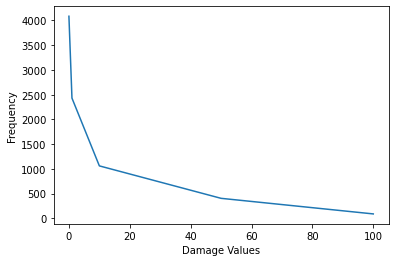

In [2]:
#Define bins
#bins2= [0, 1, 60, 100]   #Old bins
bins2 = [0, 0.00009, 1, 10, 50, 100]    #New bins
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

print(samples_per_bin2)
print(binsP2)


###The data (except target) needs to be standardize

In [3]:
#Separate target from all other data
#df_scaled = df
#df_scaled

#Separate typhoon from other features
dfs = np.split(df, [1], axis=1)
dfa = np.split(dfs[1], [36], axis=1)
#print(dfs[0], dfs[1], dfa[0], dfa[1])

#Standardaize data 
scaler = preprocessing.StandardScaler().fit(dfa[0])
X1 = scaler.transform(dfa[0])
Xnew = pd.DataFrame(X1)
display(Xnew)



,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,0.782109,...,-0.932648,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946
1,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,-0.597673,...,0.691991,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529
2,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,0.183134,...,0.009907,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326
3,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.423542,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280
4,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,2.322332,...,0.620671,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,-0.995121,-1.011089,-1.013966,-0.928759,-0.544885,1.310395,0.332660,0.482535,0.483613,0.332878,...,-0.207321,-0.209948,0.702918,1.350502,0.849154,0.035392,0.187740,-0.387371,0.409624,0.672720
8069,-0.931325,-0.876566,-0.971649,-0.838334,-0.540275,1.598024,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.597539,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787
8070,-0.980663,-0.983516,-1.010444,-0.517240,-0.506472,0.640566,-0.597476,-0.339573,-0.339482,-0.597673,...,-0.029475,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753
8071,-0.979753,-0.878516,-0.965113,-0.620712,-0.520841,0.719548,-0.629550,-0.351584,-0.351508,-0.629761,...,0.432899,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956


In [4]:
dfa[1].dtypes

DAM_perc_dmg    object
dtype: object

In [5]:
dfa[1] = dfa[1].astype(float)

In [6]:
Xnew = pd.concat([Xnew.reset_index(drop=True), dfa[1].reset_index(drop=True)], axis=1)
Xnew

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,DAM_perc_dmg
0,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,0.782109,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,-0.597673,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,0.183134,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,2.322332,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,-0.995121,-1.011089,-1.013966,-0.928759,-0.544885,1.310395,0.332660,0.482535,0.483613,0.332878,...,-0.209948,0.702918,1.350502,0.849154,0.035392,0.187740,-0.387371,0.409624,0.672720,0.000000
8069,-0.931325,-0.876566,-0.971649,-0.838334,-0.540275,1.598024,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787,0.000000
8070,-0.980663,-0.983516,-1.010444,-0.517240,-0.506472,0.640566,-0.597476,-0.339573,-0.339482,-0.597673,...,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753,0.000000
8071,-0.979753,-0.878516,-0.965113,-0.620712,-0.520841,0.719548,-0.629550,-0.351584,-0.351508,-0.629761,...,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956,0.000000


In [7]:
i=0
for feature in features:
    Xnew = Xnew.rename(columns={i: feature})
    i+=1
    
Xnew = pd.concat([dfs[0].reset_index(drop=True),Xnew.reset_index(drop=True)], axis=1)
#Xnew

In [8]:
#Xnew.dtypes

In [9]:
typhoons_lst = Xnew.typhoon.unique()
tls=typhoons_lst.tolist()

In [10]:
df_typhoon=pd.DataFrame(columns = ['typhoon', 'year'])

for i in range(len(tls)):
    df_typhoon.at[i,'typhoon']=tls[i]
    df_typhoon.at[i,'year'] = int(tls[i][-4:])
    
df_typhoon_sort = df_typhoon.sort_values('year')
df_typhoon_sort=df_typhoon_sort.reset_index(drop=True)
df_typhoon_sort

,typhoon,year
0,durian2006,2006
1,fengshen2008,2008
2,ketsana2009,2009
3,conson2010,2010
4,nesat2011,2011
5,bopha2012,2012
6,nari2013,2013
7,krosa2013,2013
8,haiyan2013,2013
9,usagi2013,2013


In [11]:
#Define an empty list to append the estimated rmse to the list
rmse_test_list=[]

#Define an empty list to append the selected typhoons to the list
test_list = []

#Define 5 empty lists to append the estimated rmse for each bin to the each list
rmse_list_1=[]
rmse_list_2=[]
rmse_list_3=[]
rmse_list_4=[]
rmse_list_5=[]

####Check the mean value of each group of typhoon to figure out most severe typhoons.

In [12]:
i_list=[38, 37, 36, 35, 34, 33, 32, 31]
for i in range(len(i_list)):
    test_list.append(df_typhoon_sort.iloc[i_list[i], 0])

print(test_list)

['molave2020', 'vongfong2020', 'vamco2020', 'goni2020', 'saudel2020', 'phanfone2019', 'nakri2019', 'kammuri2019']


In [13]:
#Reorder test_list according to typhoons'dates from months in 2019 to last one in November 2020 

test_list=['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']


In [14]:
ltl=len(test_list)
ltl

8

In [15]:
"""
An empty df with same features of main df is created in order to add selected typhoons(test_list) info to 
each column and save it as the test data.
"""
df_test=pd.DataFrame(columns = ['typhoon','HAZ_rainfall_Total',
                                      'HAZ_rainfall_max_6h',
                                      'HAZ_rainfall_max_24h',
                                      'HAZ_v_max',
                                      'HAZ_v_max_3',
                                      'HAZ_dis_track_min',
                                      'GEN_landslide_per',
                                      'GEN_stormsurge_per',
                                      'GEN_Bu_p_inSSA', 
                                      'GEN_Bu_p_LS', 
                                      'GEN_Red_per_LSbldg',
                                      'GEN_Or_per_LSblg', 
                                      'GEN_Yel_per_LSSAb', 
                                      'GEN_RED_per_SSAbldg',
                                      'GEN_OR_per_SSAbldg',
                                      'GEN_Yellow_per_LSbl',
                                      'TOP_mean_slope',
                                      'TOP_mean_elevation_m', 
                                      'TOP_ruggedness_stdev', 
                                      'TOP_mean_ruggedness',
                                      'TOP_slope_stdev', 
                                      'VUL_poverty_perc',
                                      'GEN_with_coast',
                                      'GEN_coast_length', 
                                      'VUL_Housing_Units',
                                      'VUL_StrongRoof_StrongWall', 
                                      'VUL_StrongRoof_LightWall',
                                      'VUL_StrongRoof_SalvageWall', 
                                      'VUL_LightRoof_StrongWall',
                                      'VUL_LightRoof_LightWall', 
                                      'VUL_LightRoof_SalvageWall',
                                      'VUL_SalvagedRoof_StrongWall',
                                      'VUL_SalvagedRoof_LightWall',
                                      'VUL_SalvagedRoof_SalvageWall', 
                                      'VUL_vulnerable_groups',
                                      'VUL_pantawid_pamilya_beneficiary', 
                                      'DAM_perc_dmg']) 
#df_test

,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg


### In the following cell the RMSE is calculated for different test set and added to a list for plotting.

In [16]:
while ltl!=0:

    if ltl==8:   
        df_test = Xnew[Xnew['typhoon'] == test_list[7]]
        df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[6]])
        df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[5]])
        df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[4]])
        df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[3]])
        df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[2]])
        df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[1]])
        df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[0]])

        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[7]], inplace=True)
        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[6]], inplace=True)
        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[5]], inplace=True)
        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[4]], inplace=True)
        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[3]], inplace=True)
        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[2]], inplace=True)
        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[1]], inplace=True)
        Xnew.drop(Xnew.index[Xnew['typhoon'] == test_list[0]], inplace=True)   

        display(df_test)    
        df_train=Xnew
        display(df_train)


    elif ltl < 8:

            if ltl==7:
                num=0

            elif ltl==6:
                num=1

            elif ltl==5:
                num=2

            elif ltl==4:
                num=3

            elif ltl==3:
                num=4

            elif ltl==2:
                num=5

            elif ltl==1:
                num=6

            df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])
            df_test.drop(df_test.index[df_test['typhoon'] == test_list[num]], inplace=True)



            display(df_test)
            display(df_train)


    # Split X and y from dataframe features
    X_test = df_test[features]
    X_train = df_train[features]

    y_train = df_train["DAM_perc_dmg"]
    y_test = df_test["DAM_perc_dmg"]

    bin_index_test=np.digitize(y_test, bins=binsP2)
    bin_index_train=np.digitize(y_train, bins=binsP2)


    #Random Forest
    rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5)
    
    #Random Forest_ReducedOverfitting
    #rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5, max_samples=0.7)

    rf_model=rf.fit(X_train, y_train)



    #RMSE Estimation for each bins
    y_pred_train = rf.predict(X_train)

    mse_train_idx1 = mean_squared_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    rmse_train_1 = np.sqrt(mse_train_idx1)
    mse_train_idx2 = mean_squared_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    rmse_train_2 = np.sqrt(mse_train_idx2)
    mse_train_idx3 = mean_squared_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    rmse_train_3 = np.sqrt(mse_train_idx3)
    mse_train_idx4 = mean_squared_error(y_train[bin_index_train==4], y_pred_train[bin_index_train==4])
    rmse_train_4 = np.sqrt(mse_train_idx4)
    mse_train_idx5 = mean_squared_error(y_train[bin_index_train==5], y_pred_train[bin_index_train==5])
    rmse_train_5 = np.sqrt(mse_train_idx5)


    print('----- Training_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_train_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_train_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_train_3:.2f}')
    print(f'Root mean squared error of bins_4: {rmse_train_4:.2f}')
    print(f'Root mean squared error of bins_5: {rmse_train_5:.2f}')


    y_pred = rf.predict(X_test)

    mse_idx1 = mean_squared_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    rmse_1 = np.sqrt(mse_idx1)

    if len(y_test[bin_index_test==2])==0:
        rmse_2=-1
    else:
        mse_idx2 = mean_squared_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
        rmse_2 = np.sqrt(mse_idx2)

    if len(y_test[bin_index_test==3])==0:
        rmse_3=-1
    else:
        mse_idx3 = mean_squared_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
        rmse_3 = np.sqrt(mse_idx3)

    if len(y_test[bin_index_test==4])==0:
        rmse_4=-1
    else:
        mse_idx4 = mean_squared_error(y_test[bin_index_test==4], y_pred[bin_index_test==4])
        rmse_4 = np.sqrt(mse_idx4)

    if len(y_test[bin_index_test==5])==0:
        rmse_5=-1
    else:
        mse_idx5 = mean_squared_error(y_test[bin_index_test==5], y_pred[bin_index_test==5])
        rmse_5 = np.sqrt(mse_idx5)


    print('----- Test_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_3:.2f}')
    print(f'Root mean squared error of bins_4: {rmse_4:.2f}')
    print(f'Root mean squared error of bins_5: {rmse_5:.2f}')

    rmse_list_1.append(rmse_1)
    rmse_list_2.append(rmse_2)
    rmse_list_3.append(rmse_3)
    rmse_list_4.append(rmse_4)
    rmse_list_5.append(rmse_5)


    #Different Error Estimation
    y_pred_train = rf.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mx_train = max_error(y_train, y_pred_train)
    me_train = (y_pred_train - y_train).sum()/len(y_train)

    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mx = max_error(y_test, y_pred)
    me = (y_pred - y_test).sum()/len(y_test)

    print('----- Test  ------')
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    print(f'Max error: {mx:.2f}')
    print(f"Average Error: {me:.2f}")

    print('---- Training -----')
    print(f'Mean absolute error: {mae_train:.2f}')
    print(f'Mean squared error: {mse_train:.2f}')
    print(f'Root mean squared error: {rmse_train:.2f}')
    print(f'Max error: {mx_train:.2f}')
    print(f"Average Error: {me_train:.2f}")


    score = rf.score(X_train, y_train)  
    print("Training score coefficient of determination for the model R^2: %.3f " % (score))

    rmse_test_list.append(rmse)

    #ltl means len(test_list)
    ltl=ltl-1
    ltl



rmse_test_list

/tmp/ipykernel_1346743/1244216915.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[6]])
/tmp/ipykernel_1346743/1244216915.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[5]])
/tmp/ipykernel_1346743/1244216915.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[4]])
/tmp/ipykernel_1346743/1244216915.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test=df_test.append(Xnew[Xnew['typhoon'] == test_list[3]])
/tmp/ipykernel_1346743/1244216915.py:9: FutureWarnin

,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,kammuri2019,0.251819,0.368370,0.340007,0.072635,-0.334333,-0.223672,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,1.038206
3301,kammuri2019,0.321951,1.024028,0.613993,1.551381,1.255283,-0.758349,-0.068261,1.095112,1.091582,...,-0.089043,0.507463,0.065949,0.621402,-0.091894,0.035161,-0.220981,-0.766019,-0.329254,24.047333
3302,kammuri2019,-0.870427,-0.841752,-0.846123,-0.561017,-0.513008,1.025970,-0.629550,-0.351584,-0.351508,...,-0.070763,-0.402397,-0.135896,-0.317607,-0.125805,-0.314665,-0.429307,0.541929,-0.579196,0.000000
5268,nakri2019,-0.773676,-0.913927,-0.845051,-0.714947,-0.530884,1.496320,-0.544020,-0.340907,-0.340819,...,-0.226072,0.079594,2.640732,0.165203,-0.321955,0.055398,-0.124512,-0.627993,0.814757,0.000000


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,noul2015,-0.995121,-1.011089,-1.013966,-0.928759,-0.544885,1.310395,0.332660,0.482535,0.483613,...,-0.209948,0.702918,1.350502,0.849154,0.035392,0.187740,-0.387371,0.409624,0.672720,0.000000
8069,noul2015,-0.931325,-0.876566,-0.971649,-0.838334,-0.540275,1.598024,-0.629550,-0.351584,-0.351508,...,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787,0.000000
8070,noul2015,-0.980663,-0.983516,-1.010444,-0.517240,-0.506472,0.640566,-0.597476,-0.339573,-0.339482,...,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753,0.000000
8071,noul2015,-0.979753,-0.878516,-0.965113,-0.620712,-0.520841,0.719548,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956,0.000000


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.58
Root mean squared error of bins_2: 1.63
Root mean squared error of bins_3: 3.85
Root mean squared error of bins_4: 9.69
Root mean squared error of bins_5: 26.00
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.46
Root mean squared error of bins_2: 2.15
Root mean squared error of bins_3: 5.70
Root mean squared error of bins_4: 13.91
Root mean squared error of bins_5: 62.80
----- Test  ------
Mean absolute error: 1.77
Mean squared error: 20.97
Root mean squared error: 4.58
Max error: 62.80
Average Error: 0.04
---- Training -----
Mean absolute error: 1.20
Mean squared error: 16.79
Root mean squared error: 4.10
Max error: 76.18
Average Error: 0.04
Training score coefficient of determination for the model R^2: 0.831 


/tmp/ipykernel_1346743/1244216915.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3298,kammuri2019,-0.547234,-0.392505,-0.412940,-0.700915,-0.529557,1.082180,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,2.321250
3299,kammuri2019,0.211310,0.702528,0.430880,1.095505,0.533997,-0.478838,2.545742,-0.195437,-0.195173,...,-0.398538,2.126573,1.895188,0.906086,-0.056303,0.462471,0.141656,0.718603,1.158742,8.175081
3300,kammuri2019,0.251819,0.368370,0.340007,0.072635,-0.334333,-0.223672,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,1.038206
3301,kammuri2019,0.321951,1.024028,0.613993,1.551381,1.255283,-0.758349,-0.068261,1.095112,1.091582,...,-0.089043,0.507463,0.065949,0.621402,-0.091894,0.035161,-0.220981,-0.766019,-0.329254,24.047333


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8070,noul2015,-0.980663,-0.983516,-1.010444,-0.517240,-0.506472,0.640566,-0.597476,-0.339573,-0.339482,...,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753,0.000000
8071,noul2015,-0.979753,-0.878516,-0.965113,-0.620712,-0.520841,0.719548,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.486006,-0.693494,-0.547616,-0.321955,-0.376621,-0.480336,0.416342,-0.092956,0.000000
8072,noul2015,-0.812281,-0.832468,-0.766925,-0.524996,-0.507681,0.733116,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,0.000000
5268,nakri2019,-0.773676,-0.913927,-0.845051,-0.714947,-0.530884,1.496320,-0.544020,-0.340907,-0.340819,...,-0.226072,0.079594,2.640732,0.165203,-0.321955,0.055398,-0.124512,-0.627993,0.814757,0.000000


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.65
Root mean squared error of bins_2: 1.66
Root mean squared error of bins_3: 3.87
Root mean squared error of bins_4: 9.74
Root mean squared error of bins_5: 26.08
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.41
Root mean squared error of bins_2: 2.08
Root mean squared error of bins_3: 5.47
Root mean squared error of bins_4: 13.97
Root mean squared error of bins_5: 63.65
----- Test  ------
Mean absolute error: 1.73
Mean squared error: 20.52
Root mean squared error: 4.53
Max error: 63.65
Average Error: 0.01
---- Training -----
Mean absolute error: 1.21
Mean squared error: 16.89
Root mean squared error: 4.11
Max error: 76.00
Average Error: 0.04
Training score coefficient of determination for the model R^2: 0.830 


/tmp/ipykernel_1346743/1244216915.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6150,phanfone2019,-0.111479,-0.129864,-0.019362,0.677386,0.069735,-1.290539,-0.629550,-0.351584,-0.351508,...,1.051635,-0.284212,-0.621690,0.016363,0.399481,0.534875,1.208821,0.277600,-0.019327,3.144654
6151,phanfone2019,0.332001,1.176933,0.609517,0.619430,0.018408,-1.221040,-0.629550,-0.351584,-0.351508,...,1.480898,-0.482420,-0.763560,-0.119093,0.555104,0.489096,0.432344,-0.863902,0.204791,5.982988
6152,phanfone2019,-0.184071,-0.127822,-0.050200,1.254219,0.757673,-1.330697,-0.597476,-0.343576,-0.343491,...,1.267365,-0.199596,1.069469,2.394697,-0.128941,0.415934,0.423504,1.747884,1.435476,4.072017
6153,phanfone2019,-0.841489,-0.807587,-0.877416,-0.747821,-0.533775,1.220637,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,0.000000


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3298,kammuri2019,-0.547234,-0.392505,-0.412940,-0.700915,-0.529557,1.082180,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,2.321250
3299,kammuri2019,0.211310,0.702528,0.430880,1.095505,0.533997,-0.478838,2.545742,-0.195437,-0.195173,...,-0.398538,2.126573,1.895188,0.906086,-0.056303,0.462471,0.141656,0.718603,1.158742,8.175081
3300,kammuri2019,0.251819,0.368370,0.340007,0.072635,-0.334333,-0.223672,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,1.038206
3301,kammuri2019,0.321951,1.024028,0.613993,1.551381,1.255283,-0.758349,-0.068261,1.095112,1.091582,...,-0.089043,0.507463,0.065949,0.621402,-0.091894,0.035161,-0.220981,-0.766019,-0.329254,24.047333


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.64
Root mean squared error of bins_2: 1.61
Root mean squared error of bins_3: 3.70
Root mean squared error of bins_4: 9.86
Root mean squared error of bins_5: 26.86
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.49
Root mean squared error of bins_2: 1.97
Root mean squared error of bins_3: 3.19
Root mean squared error of bins_4: 14.39
Root mean squared error of bins_5: 64.08
----- Test  ------
Mean absolute error: 1.37
Mean squared error: 15.76
Root mean squared error: 3.97
Max error: 64.08
Average Error: -0.29
---- Training -----
Mean absolute error: 1.23
Mean squared error: 17.06
Root mean squared error: 4.13
Max error: 77.77
Average Error: 0.03
Training score coefficient of determination for the model R^2: 0.822 


/tmp/ipykernel_1346743/1244216915.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7411,vongfong2020,-0.707017,-0.809889,-0.811752,-1.195528,-0.550611,1.449144,-0.629550,-0.351584,-0.351508,...,-0.440446,-0.457393,-0.725974,-0.547616,-0.321955,-0.311689,-0.426856,0.588077,-0.134781,0.000000
7412,vongfong2020,-0.387592,-0.615318,-0.413769,-0.826999,-0.539571,-0.794284,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,0.106418
7413,vongfong2020,-0.850392,-0.901455,-0.941588,-0.882994,-0.542767,-0.280569,-0.576093,-0.351584,-0.351508,...,-0.098151,0.110955,0.299725,-0.426655,-0.321955,-0.213708,-0.399827,-0.422407,0.352310,0.000000
7414,vongfong2020,-0.724407,-0.869603,-0.773343,-0.875264,-0.542367,-0.291813,-0.629550,-0.351584,-0.351508,...,1.480898,-0.482420,-0.763560,-0.119093,0.555104,0.489096,0.432344,-0.863902,0.204791,0.000000


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6150,phanfone2019,-0.111479,-0.129864,-0.019362,0.677386,0.069735,-1.290539,-0.629550,-0.351584,-0.351508,...,1.051635,-0.284212,-0.621690,0.016363,0.399481,0.534875,1.208821,0.277600,-0.019327,3.144654
6151,phanfone2019,0.332001,1.176933,0.609517,0.619430,0.018408,-1.221040,-0.629550,-0.351584,-0.351508,...,1.480898,-0.482420,-0.763560,-0.119093,0.555104,0.489096,0.432344,-0.863902,0.204791,5.982988
6152,phanfone2019,-0.184071,-0.127822,-0.050200,1.254219,0.757673,-1.330697,-0.597476,-0.343576,-0.343491,...,1.267365,-0.199596,1.069469,2.394697,-0.128941,0.415934,0.423504,1.747884,1.435476,4.072017
6153,phanfone2019,-0.841489,-0.807587,-0.877416,-0.747821,-0.533775,1.220637,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,0.000000


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.62
Root mean squared error of bins_2: 1.62
Root mean squared error of bins_3: 3.72
Root mean squared error of bins_4: 9.54
Root mean squared error of bins_5: 26.89
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.51
Root mean squared error of bins_2: 2.03
Root mean squared error of bins_3: 3.42
Root mean squared error of bins_4: 13.67
Root mean squared error of bins_5: 63.55
----- Test  ------
Mean absolute error: 1.19
Mean squared error: 13.52
Root mean squared error: 3.68
Max error: 63.55
Average Error: 0.03
---- Training -----
Mean absolute error: 1.25
Mean squared error: 16.63
Root mean squared error: 4.08
Max error: 74.32
Average Error: 0.04
Training score coefficient of determination for the model R^2: 0.823 


/tmp/ipykernel_1346743/1244216915.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5152,molave2020,1.373757,1.465158,1.091308,0.698962,0.089604,-1.450541,-0.629550,-0.351584,-0.351508,...,-0.437936,-0.315874,0.142149,-0.482209,-0.154620,-0.323766,-0.393270,-0.030760,0.148559,0.962801
5153,molave2020,-0.125229,-0.594429,-0.642175,-1.042601,-0.548508,1.066733,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,1.084137
5154,molave2020,0.062621,-0.319255,-0.134783,0.389611,-0.157295,-1.060096,2.545742,-0.195437,-0.195173,...,-0.398538,2.126573,1.895188,0.906086,-0.056303,0.462471,0.141656,0.718603,1.158742,2.709588
6559,saudel2020,0.597376,0.539466,0.621059,-0.881719,-0.542702,0.833865,0.043997,0.649359,0.650638,...,0.510577,0.179685,1.173637,3.329863,-0.119505,0.198896,0.362355,-0.335634,0.837047,0.017649


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7411,vongfong2020,-0.707017,-0.809889,-0.811752,-1.195528,-0.550611,1.449144,-0.629550,-0.351584,-0.351508,...,-0.440446,-0.457393,-0.725974,-0.547616,-0.321955,-0.311689,-0.426856,0.588077,-0.134781,0.000000
7412,vongfong2020,-0.387592,-0.615318,-0.413769,-0.826999,-0.539571,-0.794284,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,0.106418
7413,vongfong2020,-0.850392,-0.901455,-0.941588,-0.882994,-0.542767,-0.280569,-0.576093,-0.351584,-0.351508,...,-0.098151,0.110955,0.299725,-0.426655,-0.321955,-0.213708,-0.399827,-0.422407,0.352310,0.000000
7414,vongfong2020,-0.724407,-0.869603,-0.773343,-0.875264,-0.542367,-0.291813,-0.629550,-0.351584,-0.351508,...,1.480898,-0.482420,-0.763560,-0.119093,0.555104,0.489096,0.432344,-0.863902,0.204791,0.000000


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.57
Root mean squared error of bins_2: 1.68
Root mean squared error of bins_3: 3.56
Root mean squared error of bins_4: 9.62
Root mean squared error of bins_5: 26.74
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.64
Root mean squared error of bins_2: 1.56
Root mean squared error of bins_3: 3.02
Root mean squared error of bins_4: 13.51
Root mean squared error of bins_5: -1.00
----- Test  ------
Mean absolute error: 1.37
Mean squared error: 10.69
Root mean squared error: 3.27
Max error: 31.22
Average Error: -0.01
---- Training -----
Mean absolute error: 1.21
Mean squared error: 15.90
Root mean squared error: 3.99
Max error: 72.83
Average Error: 0.03
Training score coefficient of determination for the model R^2: 0.825 


/tmp/ipykernel_1346743/1244216915.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150,molave2020,0.716961,1.007410,0.750261,0.282962,-0.224763,-1.427649,-0.629550,-0.351584,-0.351508,...,-0.510934,1.104311,0.540170,-0.302497,-0.112919,-0.145529,0.172241,-0.015434,0.185492,0.218679
5151,molave2020,0.262098,-0.286669,-0.238420,-1.125797,-0.549962,1.463717,-0.629550,-0.351584,-0.351508,...,-0.554691,-0.183199,0.629645,-0.547616,-0.321955,-0.271035,-0.480336,0.777320,-0.460388,0.014571
5152,molave2020,1.373757,1.465158,1.091308,0.698962,0.089604,-1.450541,-0.629550,-0.351584,-0.351508,...,-0.437936,-0.315874,0.142149,-0.482209,-0.154620,-0.323766,-0.393270,-0.030760,0.148559,0.962801
5153,molave2020,-0.125229,-0.594429,-0.642175,-1.042601,-0.548508,1.066733,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,1.084137


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7413,vongfong2020,-0.850392,-0.901455,-0.941588,-0.882994,-0.542767,-0.280569,-0.576093,-0.351584,-0.351508,...,-0.098151,0.110955,0.299725,-0.426655,-0.321955,-0.213708,-0.399827,-0.422407,0.352310,0.000000
7414,vongfong2020,-0.724407,-0.869603,-0.773343,-0.875264,-0.542367,-0.291813,-0.629550,-0.351584,-0.351508,...,1.480898,-0.482420,-0.763560,-0.119093,0.555104,0.489096,0.432344,-0.863902,0.204791,0.000000
7415,vongfong2020,-0.840635,-0.878516,-0.972080,-1.227200,-0.550777,0.684297,-0.629550,-0.351584,-0.351508,...,-0.070763,-0.402397,-0.135896,-0.317607,-0.125805,-0.314665,-0.429307,0.541929,-0.579196,0.000000
6559,saudel2020,0.597376,0.539466,0.621059,-0.881719,-0.542702,0.833865,0.043997,0.649359,0.650638,...,0.510577,0.179685,1.173637,3.329863,-0.119505,0.198896,0.362355,-0.335634,0.837047,0.017649


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.56
Root mean squared error of bins_2: 1.70
Root mean squared error of bins_3: 3.65
Root mean squared error of bins_4: 9.55
Root mean squared error of bins_5: 27.02
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.56
Root mean squared error of bins_2: 1.59
Root mean squared error of bins_3: 3.14
Root mean squared error of bins_4: 13.53
Root mean squared error of bins_5: -1.00
----- Test  ------
Mean absolute error: 1.35
Mean squared error: 10.88
Root mean squared error: 3.30
Max error: 31.87
Average Error: -0.03
---- Training -----
Mean absolute error: 1.21
Mean squared error: 16.18
Root mean squared error: 4.02
Max error: 73.00
Average Error: 0.04
Training score coefficient of determination for the model R^2: 0.822 


/tmp/ipykernel_1346743/1244216915.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,goni2020,-0.336838,-0.100899,-0.362394,0.580991,-0.014023,-1.406280,0.476991,-0.031282,-0.030822,...,-0.356972,0.133439,0.769383,0.542055,0.049751,0.034305,-0.335285,-0.221890,0.087693,0.016202
1727,goni2020,-0.841444,-0.754854,-0.842499,-0.396352,-0.484627,-0.000070,-0.437108,-0.351584,-0.351508,...,-0.142226,-0.290938,-0.307382,-0.418504,-0.211849,-0.167952,-0.193891,1.197934,0.219293,0.000000
1728,goni2020,0.325490,0.996826,0.375148,0.743019,0.131482,-1.171604,2.545742,-0.195437,-0.195173,...,-0.398538,2.126573,1.895188,0.906086,-0.056303,0.462471,0.141656,0.718603,1.158742,11.000463
1729,goni2020,-0.388322,-0.198812,-0.397219,-0.672655,-0.526711,-0.748506,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,0.436047


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150,molave2020,0.716961,1.007410,0.750261,0.282962,-0.224763,-1.427649,-0.629550,-0.351584,-0.351508,...,-0.510934,1.104311,0.540170,-0.302497,-0.112919,-0.145529,0.172241,-0.015434,0.185492,0.218679
5151,molave2020,0.262098,-0.286669,-0.238420,-1.125797,-0.549962,1.463717,-0.629550,-0.351584,-0.351508,...,-0.554691,-0.183199,0.629645,-0.547616,-0.321955,-0.271035,-0.480336,0.777320,-0.460388,0.014571
5152,molave2020,1.373757,1.465158,1.091308,0.698962,0.089604,-1.450541,-0.629550,-0.351584,-0.351508,...,-0.437936,-0.315874,0.142149,-0.482209,-0.154620,-0.323766,-0.393270,-0.030760,0.148559,0.962801
5153,molave2020,-0.125229,-0.594429,-0.642175,-1.042601,-0.548508,1.066733,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,1.084137


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.52
Root mean squared error of bins_2: 1.62
Root mean squared error of bins_3: 3.59
Root mean squared error of bins_4: 9.71
Root mean squared error of bins_5: 27.09
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.53
Root mean squared error of bins_2: 0.86
Root mean squared error of bins_3: 3.30
Root mean squared error of bins_4: 13.82
Root mean squared error of bins_5: -1.00
----- Test  ------
Mean absolute error: 1.35
Mean squared error: 12.51
Root mean squared error: 3.54
Max error: 31.30
Average Error: -0.39
---- Training -----
Mean absolute error: 1.20
Mean squared error: 16.08
Root mean squared error: 4.01
Max error: 75.57
Average Error: 0.03
Training score coefficient of determination for the model R^2: 0.821 


/tmp/ipykernel_1346743/1244216915.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_test[df_test['typhoon'] == test_list[num]])


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
6800,vamco2020,0.271298,0.341942,0.347412,-0.165874,-0.425196,-1.030969,-0.212592,5.102888,5.100166,...,-0.346117,-0.433989,-0.758678,-0.547616,-0.321955,-0.337477,-0.448095,-0.947447,-1.150918,0.000000
6801,vamco2020,1.704740,0.525577,1.356928,-0.400363,-0.485447,-0.463913,1.257450,0.018098,0.018618,...,0.810547,0.081525,0.138999,1.441321,-0.321955,-0.376621,-0.196669,-0.195917,-0.346559,0.000000
6802,vamco2020,0.701594,0.235326,0.104512,-1.056908,-0.548821,0.533616,-0.629550,-0.351584,-0.351508,...,-0.583838,-0.481673,-0.493736,-0.547616,-0.321955,-0.298837,-0.480336,-0.542169,0.460075,0.000000
6803,vamco2020,1.973405,0.990513,1.697358,-0.304684,-0.463980,-0.708142,1.391090,1.694343,1.692870,...,-0.357750,-0.021535,0.320360,-0.547616,-0.321955,-0.274242,-0.396013,-0.378751,-0.166851,0.056513
6804,vamco2020,-0.177600,-0.468540,-0.269478,-0.429711,-0.491240,-0.688008,-0.629550,-0.351584,-0.351508,...,0.132192,-0.440675,-0.601943,-0.280123,-0.321955,-0.088408,-0.331972,-0.404409,-0.692202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7093,vamco2020,0.034514,-0.056893,-0.108753,0.014783,-0.359428,-0.995108,-0.629550,-0.351584,-0.351508,...,0.041467,-0.362893,-0.578227,-0.130118,0.059516,0.008954,-0.142916,-0.798363,-0.847003,0.000000
7094,vamco2020,-0.090449,-0.451829,-0.232338,-0.482835,-0.500840,-0.633061,-0.629550,-0.351584,-0.351508,...,-0.165655,-0.388452,-0.583216,-0.422637,-0.321955,-0.250377,-0.189196,-0.805064,-0.840787,0.000000
7095,vamco2020,0.689663,0.676997,0.376788,-0.988594,-0.547057,0.225028,-0.597476,-0.339573,-0.339482,...,-0.178278,-0.487495,-0.697345,-0.446611,-0.321955,-0.131755,-0.413109,-0.758790,-1.119753,0.045055
7096,vamco2020,1.973764,1.283760,1.632079,0.352291,-0.181868,-1.052706,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,7.277824


,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,0.429453,0.901680,0.766418,1.592258,1.332271,-1.443648,0.781691,0.473193,0.474260,...,-0.388957,0.337830,2.004665,3.945376,-0.321955,-0.275767,-0.231135,0.495246,1.947946,3.632568
1,durian2006,-1.002249,-1.004823,-1.004232,-0.896964,-0.543458,1.423220,-0.597476,-0.351584,-0.351508,...,1.116440,-0.106247,0.038993,1.914435,0.023188,-0.049568,-0.143622,0.763418,0.238529,0.000000
2,durian2006,-0.878043,-0.743714,-0.829731,-0.777769,-0.536155,1.288795,0.182983,-0.180756,-0.180475,...,-0.189419,-0.292472,0.174483,-0.207586,-0.321955,-0.321666,-0.254022,-0.072272,0.744326,0.000000
3,durian2006,-0.952819,-0.845094,-0.922008,-0.715243,-0.530911,1.066918,-0.629550,-0.351584,-0.351508,...,-0.025027,-0.289853,-0.416442,-0.443236,-0.188433,-0.376621,-0.098239,-0.447767,0.534280,0.000000
4,durian2006,-0.963981,-0.924749,-0.936450,-0.793073,-0.537281,1.120728,2.321226,-0.303539,-0.303405,...,-0.452411,-0.240474,1.201765,-0.547616,-0.321955,-0.257594,-0.480336,-0.587862,0.978342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,goni2020,-0.336838,-0.100899,-0.362394,0.580991,-0.014023,-1.406280,0.476991,-0.031282,-0.030822,...,-0.356972,0.133439,0.769383,0.542055,0.049751,0.034305,-0.335285,-0.221890,0.087693,0.016202
1727,goni2020,-0.841444,-0.754854,-0.842499,-0.396352,-0.484627,-0.000070,-0.437108,-0.351584,-0.351508,...,-0.142226,-0.290938,-0.307382,-0.418504,-0.211849,-0.167952,-0.193891,1.197934,0.219293,0.000000
1728,goni2020,0.325490,0.996826,0.375148,0.743019,0.131482,-1.171604,2.545742,-0.195437,-0.195173,...,-0.398538,2.126573,1.895188,0.906086,-0.056303,0.462471,0.141656,0.718603,1.158742,11.000463
1729,goni2020,-0.388322,-0.198812,-0.397219,-0.672655,-0.526711,-0.748506,1.588878,0.055466,0.056031,...,-0.521536,3.603347,1.607950,0.709216,-0.202864,-0.263772,-0.170517,0.195202,0.699308,0.436047


----- Training_bins_RMSE  ------
Root mean squared error of bins_1: 0.59
Root mean squared error of bins_2: 1.64
Root mean squared error of bins_3: 3.57
Root mean squared error of bins_4: 9.59
Root mean squared error of bins_5: 27.05
----- Test_bins_RMSE  ------
Root mean squared error of bins_1: 0.80
Root mean squared error of bins_2: 0.81
Root mean squared error of bins_3: 3.11
Root mean squared error of bins_4: 14.31
Root mean squared error of bins_5: -1.00
----- Test  ------
Mean absolute error: 0.95
Mean squared error: 6.80
Root mean squared error: 2.61
Max error: 31.39
Average Error: 0.01
---- Training -----
Mean absolute error: 1.22
Mean squared error: 15.82
Root mean squared error: 3.98
Max error: 72.65
Average Error: 0.04
Training score coefficient of determination for the model R^2: 0.820 


[4.579011673753238,
 4.530176706005421,
 3.970290771249511,
 3.677308530551903,
 3.270034629965193,
 3.2985108483617833,
 3.536405054259741,
 2.608568499723736]

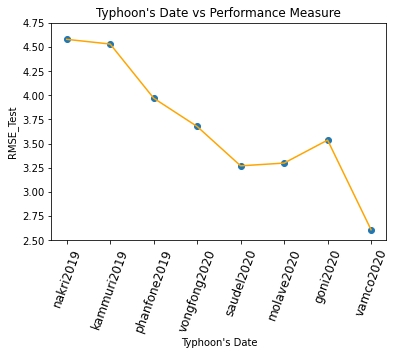

In [17]:
#Plot of RMSE estimation according to 8 different test sets

import matplotlib.pyplot as plt
import numpy as np

x = ['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']
y = rmse_test_list

plt.scatter(x, y, cmap='viridis')

#obtain m (slope) and b(intercept) of linear regression line
#m, b = np.polyfit(x, y, 1)
plt.plot(x, y, color='orange')


plt.xlabel("Typhoon's Date", fontsize=10)
plt.ylabel('RMSE_Test', fontsize=10)
plt.title("Typhoon's Date vs Performance Measure")

np.rot90(plt.xticks(rotation=70, fontsize=12))
plt.yticks(np.arange(2.5,5.0,step=0.25))
plt.show()

### Plots per bins

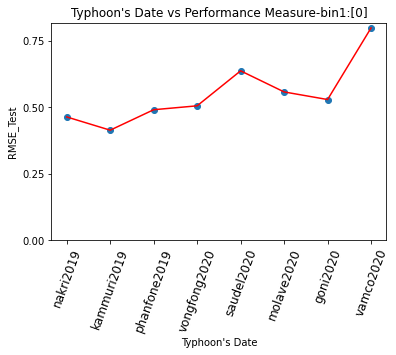

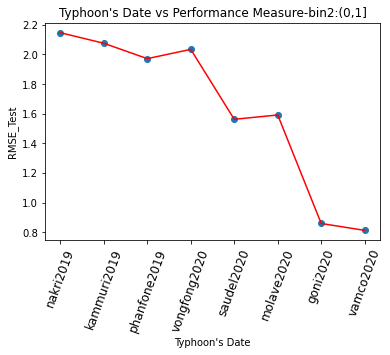

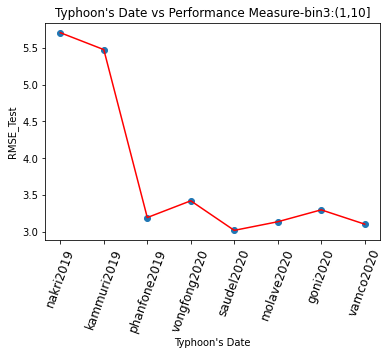

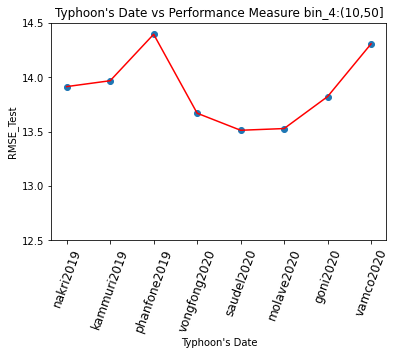

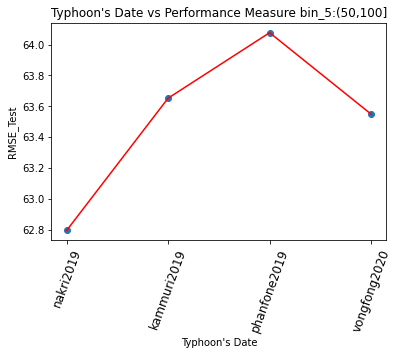

In [18]:
import matplotlib.pyplot as plt
import numpy as np

#Plot RMSE estimation of bin_1 based on 8 different test sets    
x = ['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']
y = rmse_list_1

plt.scatter(x, y, cmap='viridis')
plt.plot(x, y, color='r')

plt.xlabel("Typhoon's Date", fontsize=10)
plt.ylabel('RMSE_Test', fontsize=10)
plt.title("Typhoon's Date vs Performance Measure-bin1:[0]")

np.rot90(plt.xticks(rotation=70, fontsize=12))
plt.yticks(np.arange(0.0,1.0,step=0.25))
plt.show()


#Plot RMSE estimation of bin_2 based on 8 different test sets  
x = ['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']
y = rmse_list_2

plt.scatter(x, y, cmap='viridis')
plt.plot(x, y, color='r')

plt.xlabel("Typhoon's Date", fontsize=10)
plt.ylabel('RMSE_Test', fontsize=10)
plt.title("Typhoon's Date vs Performance Measure-bin2:(0,1]")

np.rot90(plt.xticks(rotation=70, fontsize=12))
#plt.yticks(np.arange(0.0,1.0,step=0.25))
plt.show()


#Plot RMSE estimation of bin_3 based on 8 different test sets    
x = ['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']
y = rmse_list_3

plt.scatter(x, y, cmap='viridis')
plt.plot(x, y, color='r')

plt.xlabel("Typhoon's Date", fontsize=10)
plt.ylabel('RMSE_Test', fontsize=10)
plt.title("Typhoon's Date vs Performance Measure-bin3:(1,10]")

np.rot90(plt.xticks(rotation=70, fontsize=12))
#plt.yticks(np.arange(0.0,1.0,step=0.25))
plt.show()


#Plot RMSE estimation of bin_4 based on 8 different test sets    
x = ['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']
y = rmse_list_4

plt.scatter(x, y, cmap='viridis')
plt.plot(x, y, color='r')

plt.xlabel("Typhoon's Date", fontsize=10)
plt.ylabel('RMSE_Test', fontsize=10)
plt.title("Typhoon's Date vs Performance Measure bin_4:(10,50]")

np.rot90(plt.xticks(rotation=70, fontsize=12))
plt.yticks(np.arange(12.5,14.75,step=0.5))
plt.show()


#Plot RMSE estimation of bin_5 based on 8 different test sets
x = ['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']
y = rmse_list_5


index = [i for i,j in enumerate(y) if j == -1]
for i in range(len(index)):
    a=index[0]
    typhoon_name = x[a]
    x.remove(typhoon_name)
    y.remove(-1)

plt.scatter(x, y, cmap='viridis')
plt.plot(x, y, color='r')

plt.xlabel("Typhoon's Date", fontsize=10)
plt.ylabel('RMSE_Test', fontsize=10)
plt.title("Typhoon's Date vs Performance Measure bin_5:(50,100]")

np.rot90(plt.xticks(rotation=70, fontsize=12))
#plt.yticks(np.arange(46,59,step=1))
plt.show()

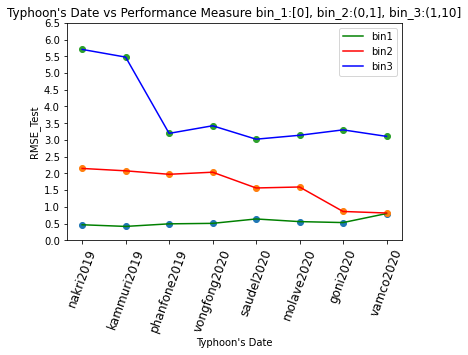

In [19]:
"""
Due to the fact that the calculated RMSE for the first three bins are more or less in the same range so we plot them
in one figure.
Plot RMSE estimation of bin(1 & 2 & 3) based on 8 different test sets
"""

x = ['nakri2019', 'kammuri2019', 'phanfone2019', 'vongfong2020', 'saudel2020', 'molave2020', 'goni2020', 'vamco2020']
y = rmse_list_1
y2 = rmse_list_2
y3 = rmse_list_3


plt.plot(x, y, 'g', label='Line y1')
plt.plot(x, y2, 'r', label='Line y2')
plt.plot(x, y3, 'b', label='Line y3')

plt.scatter(x, y, cmap='viridis')
plt.scatter(x, y2, cmap='viridis')
plt.scatter(x, y3, cmap='viridis')


#create legend
labels= ["bin1","bin2","bin3"]
plt.legend(labels)


plt.xlabel("Typhoon's Date", fontsize=10)
plt.ylabel('RMSE_Test', fontsize=10)
plt.title("Typhoon's Date vs Performance Measure bin_1:[0], bin_2:(0,1], bin_3:(1,10]")

np.rot90(plt.xticks(rotation=70, fontsize=12))
plt.yticks(np.arange(0.0,7.0,step=0.5))
plt.show()